In [1]:
from collections import defaultdict, deque
from operator import itemgetter
import networkx as nx
import statistics
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [176]:
def pagerank(G, alpha=0.85, personalization=None, 
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight', 
             dangling=None): 
    
    if len(G) == 0: 
        return {} 
  
    if not G.is_directed(): 
        D = G.to_directed() 
    else: 
        D = G 
  
    # Create a copy in (right) stochastic form 
    W = nx.stochastic_graph(D, weight=weight) 
    N = W.number_of_nodes() 
  
    # Choose fixed starting vector if not given 
    if nstart is None: 
        x = dict.fromkeys(W, 1.0 / N) 
    else: 
        # Normalized nstart vector 
        s = float(sum(nstart.values())) 
        x = dict((k, v / s) for k, v in nstart.items()) 
  
    if personalization is None: 
  
        # Assign uniform personalization vector if not given 
        p = dict.fromkeys(W, 1.0 / N) 
    else: 
        missing = set(G) - set(personalization) 
        if missing: 
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing) 
        s = float(sum(personalization.values())) 
        p = dict((k, v / s) for k, v in personalization.items()) 
  
    if dangling is None: 
  
        # Use personalization vector if dangling vector not specified 
        dangling_weights = p 
    else: 
        missing = set(G) - set(dangling) 
        if missing: 
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing) 
        s = float(sum(dangling.values())) 
        dangling_weights = dict((k, v/s) for k, v in dangling.items()) 
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0] 
  
    # power iteration: make up to max_iter iterations 
    for _ in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0) 
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
  
            # this matrix multiply looks odd because it is 
            # doing a left multiply x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight] 
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n] 
  
        # check convergence, l1 norm 
        err = sum([abs(x[n] - xlast[n]) for n in x]) 
        if err < N*tol:
            X = pd.DataFrame({'Node':x.keys(),'Page_rank':x.values()})
            return X
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter) 
    

def shortest_paths(G,source,cutoff = None):
    try:
        level=0                  # the current level
        nextlevel={source:1}       # list of nodes to check at next level
        paths={source:[source]}  # paths dictionary  (paths to key from source)
        if cutoff==0:
            return paths
        while nextlevel:
            thislevel=nextlevel
            nextlevel={}
            for v in thislevel:
                for w in G[v]:
                    if w not in paths:
                        paths[w]=paths[v]+[w]
                        nextlevel[w]=1
            level=level+1
            if (cutoff is not None and cutoff <= level):  break
        return paths
    except:
        print('node not found')   
    
def get_nodes_with_n_clicks(start_node,clicks):
    df_clicks = pd.DataFrame({"Node":{node:len(lista) - 1 for node,lista in shortest_paths(Gtup,start_node).items()}.keys(),"Clicks":{node:len(lista) - 1 for node,lista in shortest_paths(Gtup,start_node).items()}.values()})
    print('from node {} you can reach {} nodes with {} clicks'.format(start_node,len(set(df_clicks[df_clicks.Clicks == clicks].Node)),clicks))
    return set(df_clicks[df_clicks.Clicks == clicks].Node)

def get_subgraph(C0,C1):
    nodes = (
    node
    for node, data
    in Gtup.nodes(data=True)
    if data.get("category") == C0 or data.get('category') == C1
    )

    subgraph = Gtup.subgraph(nodes)
    if len(subgraph.nodes) <= 500:
        col = []
        for node in subgraph.nodes.data():
            if list(node[1].values())[0] == C0:
                col.append('blue')
            else:
                col.append('red')
        print('blue = C0 red = C1')
        #pos = nx.spring_layout(subgraph)
        plt.figure()
        nx.draw(subgraph, with_attributes=True,node_color=col,node_size=50)
        plt.show()
        print(subgraph.edges)
    else:
        print("Articles:",len(subgraph.nodes()),"\nHyperlinks:",len(subgraph.edges()))
def get_dist_from_cat(Gtup,start,end,cat_dict):
    nodes = (
    node
    for node, data
    in Gtup.nodes(data=True)
    if data.get("category") == start or data.get('category') == end
    )
    subgraph = Gtup.subgraph(nodes)
    dist = []
    for node in cat_dict[start]:
        dist.append({node:len(lista) - 1 for node,lista in shortest_paths(subgraph,node).items()})
    return dist
    

def compute_dist(graph,inp_cat, catdict): #input: a graph, an input category and a dictionary of categories
    inpnodes = [node for node,data in list(Gtup.nodes.data("category")) if data == inp_cat]
    #nodes of the input category
    bfssol=[] #the list of dictionary of distances from every point of the graph
    if len(inpnodes) > 0:
        for node in tqdm(inpnodes):
            bfssol.append({node:{len(lista) - 1 for nodes,lista in shortest_paths(Gtup,node).items()}})
            #bfssol.append(shortest_paths(Gtup,node))
        with open('bfssol_2.pickle', 'wb') as handle: #store the list in an external file
            pickle.dump(bfssol, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
get_subgraph('Drama_Desk_Award_winners','Metro-Goldwyn-Mayer_films')
# nodes = (
# node
# for node, data
# in Gtup.nodes(data=True)
# if data.get("category") == 'Drama_Desk_Award_winners' or data.get('category') == 'Metro-Goldwyn-Mayer_films'
# )

# subgraph = Gtup.subgraph(nodes)

# ind_sub = nx.Graph()
# ind_sub.add_edges_from(subgraph.edges)
# print(nx.info(ind_sub))
# print(nx.is_connected(ind_sub))
# if len(ind_sub.nodes) <= 300:
#         col = []
#         for node in subgraph.nodes.data():
#             if list(node[1].values())[0] == 'Drama_Desk_Award_winners':
#                 col.append('blue')
#             else:
#                 col.append('red')
#         print('blue = C0 red = C1')
#     #pos = nx.spring_layout(subgraph)
#         plt.figure()
#         nx.draw(ind_sub,node_size=50)
#         plt.show()

# else:
#     print("Articles:",len(ind_sub.nodes()),"\nHyperlinks:",len(ind_sub.edges()))

In [3]:
df = pd.read_csv('dataset/wikigraph_reduced.csv',sep = "\t",header = 0,names=["source","destination"])
# names = pd.read_csv('dataset/wiki-topcats-page-names.txt',sep = '\t',header = None)
# cat = pd.read_csv('dataset/wiki-topcats-categories.txt',sep = '\t',header=None)

In [ ]:
df[(df.source == 95)|(df.destination == 95)]

In [4]:
#connections
df_tuples=[(row["source"],row["destination"]) for idx,row in df.iterrows()]
df_dict=defaultdict(list)
for idx,row in df.iterrows():
    df_dict[row["source"]].append(row["destination"])

In [ ]:
pickle.dump(df_dict,open('dataset/df_dict.p','wb'))

In [5]:
#categories
categories = {}
with open('dataset/wiki-topcats-categories.txt', 'r') as f:    
    for i in f:
        i = i.strip('').lstrip('Category:').replace(';','').split()
        key = i[0]
        value = list(map(int, i[1:]))
        categories.update({key:value})
cat_adj = {}
# just one category per page
for i in categories.keys():
    for j in categories[i]:
        cat.update({j:{'category':i}})
#del categories

In [171]:
{k: cat[k] for k in list(cat)[:5]}

TypeError: string indices must be integers

In [ ]:
#page names
with open('dataset/wiki-topcats-page-names.txt', 'r') as f:
    pagenames = [' '.join(i.split()) for i in f]

### RQ1

### Is the graph directed?

In [ ]:
indicatorD=False
first_key=next(iter(df_dict)) # first key (node 52)
#tuple (source_node, list of destination nodes)
first_key_tup=(first_key,df_dict[first_key])# (52, [401135, 1069112, 1163551])
for dest in first_key_tup[1]:#check when destination is source
    if first_key not in df_dict[dest]: #if 95 is not the destionation node for [401135, 1069112, 1163551]
        indicatorD=True #then it is directed graph
if indicatorD==True:
    print("Graph is directed")
else:
    print("Graph is undirected")

### How many articles? How many hyperlinks?

In [6]:
Gtup = nx.DiGraph()
Gtup.add_edges_from(df_tuples)
print("Articles:",len(Gtup.nodes()),"\nHyperlinks:",len(Gtup.edges()))

Articles: 98343 
Hyperlinks: 483094


### Compute the average number of links in an arbitrary page.

In [ ]:
lens = []
for node,edges in df_dict.items():
    lens.append(len(edges))
np.array(lens).mean()

### What is the graph density?
### Graph Density(Undirected) is defined as: \begin{equation*} \mathbf{D} = \frac{2 \times \mathbf{E}}{\mathbf{V}(\mathbf{V} - 1)} \end{equation*}
### Graph Density(Directed) is defined as: \begin{equation*} \mathbf{D} = \frac{\mathbf{E}}{\mathbf{V}(\mathbf{V} - 1)} \end{equation*}
### Where:
### \begin{equation*} E = n° Edges \end{equation*} 
### \begin{equation*} V = n° Vertices \end{equation*} 

In [ ]:
density = (len(Gtup.edges()))/(len(Gtup.nodes())*(len(Gtup.nodes()) - 1))
density_nx = nx.density(Gtup)
print('graph density is {},so really close to 0 that\'s why we can say that the graph is higly sparse'.format(density))
print('computed density by me: {} \ncomputed density by networkx package {}'.format(density,density_nx))

### Visualize the nodes' degree distribution

In [ ]:
degree_freq = nx.degree_histogram(Gtup)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees, degree_freq,'o') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('loglog plot')
plt.figure(figsize=(12, 8)) 
plt.plot(degrees, degree_freq) 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('distplot')

## RQ2

### Define a function that returns the set of all pages that a user can reach within d clicks starting from a page v

In [ ]:
get_nodes_with_n_clicks(153,3)

## RQ3

In [7]:
nx.set_node_attributes(Gtup, cat_adj)
del cat_adj

In [8]:
# we need to remove all unused categories from categories
used_cat = list(pd.DataFrame(set(Gtup.nodes.data('category')))[1].unique())

In [9]:
categories_reduced = {k:v for k,v in categories.items() if k in used_cat}
del categories

In [ ]:
Gtup.nodes(data='category')

In [ ]:
nodes = (
    node
    for node, data
    in Gtup.nodes(data=True)
    if data.get("category") == '1957_films'
)

subgraph = Gtup.subgraph(nodes)
pos = nx.spring_layout(subgraph)

plt.figure()
nx.draw(subgraph, pos=pos)
plt.show()

## RQ4

### Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

blue = C0 red = C1


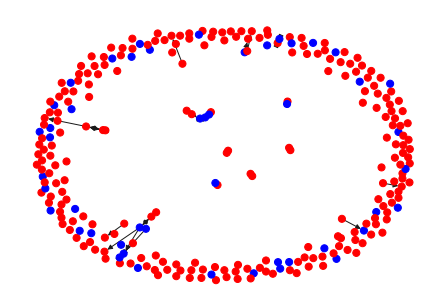

[(1225217, 1504106), (1064970, 1062724), (1064970, 1064230), (1152539, 1152541), (1152541, 1152539), (1058421, 1063286), (1503892, 1055179), (1067671, 1060880), (705700, 1065363), (1058991, 1059578), (1058991, 1225217), (1224929, 1061850), (1066728, 1060615), (1059054, 1063357), (1059578, 1058991), (1752831, 1060137), (1060615, 1066728), (1064230, 1062724), (1060137, 1752831), (1068333, 1058409), (1253687, 1065379), (1062724, 1061220), (1062724, 1064230), (1062215, 1164204), (1504106, 1060615), (1057137, 1163150), (1063286, 1058421), (1061760, 1060889), (1061760, 1061277), (1061760, 1061880), (1163150, 1057137), (1166736, 1064423), (1062801, 1061850), (1061277, 1061350), (1061277, 1061760), (1065379, 1253687), (1164204, 1062215), (1056699, 1056701), (1056701, 1056699), (1061850, 1061880), (1061350, 1061277)]


In [173]:
get_subgraph('Drama_Desk_Award_winners','Metro-Goldwyn-Mayer_films')

## RQ5

In [154]:
inputcat = 'American_film_actors'
compute_dist(Gtup,inputcat,categories_reduced)








  0%|                                                                                         | 0/4043 [00:00<?, ?it/s]






  0%|                                                                                 | 1/4043 [00:00<31:26,  2.14it/s]






  0%|                                                                                 | 2/4043 [00:01<46:01,  1.46it/s]






  0%|                                                                                 | 3/4043 [00:02<39:53,  1.69it/s]






  0%|                                                                                 | 4/4043 [00:02<41:37,  1.62it/s]






  0%|                                                                                 | 5/4043 [00:03<35:54,  1.87it/s]






  0%|                                                                                 | 6/4043 [00:03<38:14,  1.76it/s]






  0%|▏                                                                                | 7/4043 [00:04<42:33,  1

  1%|█                                                                               | 56/4043 [00:30<36:19,  1.83it/s]






  1%|█▏                                                                              | 57/4043 [00:31<41:09,  1.61it/s]






  1%|█▏                                                                              | 58/4043 [00:32<37:08,  1.79it/s]






  1%|█▏                                                                              | 59/4043 [00:32<40:43,  1.63it/s]






  1%|█▏                                                                              | 60/4043 [00:33<36:06,  1.84it/s]






  2%|█▏                                                                              | 61/4043 [00:33<32:00,  2.07it/s]






  2%|█▏                                                                              | 62/4043 [00:34<37:28,  1.77it/s]






  2%|█▏                                                                              | 63/4043 [00:34<40:00,  1.66it/s

  3%|██▏                                                                            | 111/4043 [01:01<29:23,  2.23it/s]






  3%|██▏                                                                            | 112/4043 [01:01<33:11,  1.97it/s]






  3%|██▏                                                                            | 113/4043 [01:02<29:57,  2.19it/s]






  3%|██▏                                                                            | 114/4043 [01:02<34:51,  1.88it/s]






  3%|██▏                                                                            | 115/4043 [01:03<32:47,  2.00it/s]






  3%|██▎                                                                            | 116/4043 [01:04<36:17,  1.80it/s]






  3%|██▎                                                                            | 117/4043 [01:04<32:05,  2.04it/s]






  3%|██▎                                                                            | 118/4043 [01:05<35:11,  1.86it/s

  4%|███▎                                                                           | 168/4043 [01:31<39:20,  1.64it/s]






  4%|███▎                                                                           | 169/4043 [01:31<34:01,  1.90it/s]






  4%|███▎                                                                           | 170/4043 [01:32<40:14,  1.60it/s]






  4%|███▎                                                                           | 171/4043 [01:32<35:19,  1.83it/s]






  4%|███▎                                                                           | 172/4043 [01:33<39:37,  1.63it/s]






  4%|███▍                                                                           | 173/4043 [01:33<34:51,  1.85it/s]






  4%|███▍                                                                           | 174/4043 [01:34<31:29,  2.05it/s]






  4%|███▍                                                                           | 175/4043 [01:35<35:38,  1.81it/s

  6%|████▍                                                                          | 224/4043 [02:00<33:21,  1.91it/s]






  6%|████▍                                                                          | 225/4043 [02:00<30:04,  2.12it/s]






  6%|████▍                                                                          | 226/4043 [02:01<34:47,  1.83it/s]






  6%|████▍                                                                          | 227/4043 [02:01<30:24,  2.09it/s]






  6%|████▍                                                                          | 228/4043 [02:02<33:34,  1.89it/s]






  6%|████▍                                                                          | 229/4043 [02:02<30:26,  2.09it/s]






  6%|████▍                                                                          | 230/4043 [02:03<33:20,  1.91it/s]






  6%|████▌                                                                          | 231/4043 [02:03<29:40,  2.14it/s

  7%|█████▍                                                                         | 280/4043 [02:29<29:43,  2.11it/s]






  7%|█████▍                                                                         | 281/4043 [02:29<33:49,  1.85it/s]






  7%|█████▌                                                                         | 282/4043 [02:30<30:00,  2.09it/s]






  7%|█████▌                                                                         | 283/4043 [02:30<33:23,  1.88it/s]






  7%|█████▌                                                                         | 284/4043 [02:31<29:32,  2.12it/s]






  7%|█████▌                                                                         | 285/4043 [02:31<32:42,  1.92it/s]






  7%|█████▌                                                                         | 286/4043 [02:32<29:31,  2.12it/s]






  7%|█████▌                                                                         | 287/4043 [02:32<26:50,  2.33it/s

  8%|██████▌                                                                        | 337/4043 [02:59<30:12,  2.04it/s]






  8%|██████▌                                                                        | 338/4043 [02:59<33:24,  1.85it/s]






  8%|██████▌                                                                        | 339/4043 [03:00<30:10,  2.05it/s]






  8%|██████▋                                                                        | 340/4043 [03:00<34:10,  1.81it/s]






  8%|██████▋                                                                        | 341/4043 [03:01<30:47,  2.00it/s]






  8%|██████▋                                                                        | 342/4043 [03:02<34:23,  1.79it/s]






  8%|██████▋                                                                        | 343/4043 [03:02<30:54,  2.00it/s]






  9%|██████▋                                                                        | 344/4043 [03:03<35:28,  1.74it/s

 10%|███████▋                                                                       | 393/4043 [03:29<33:50,  1.80it/s]






 10%|███████▋                                                                       | 394/4043 [03:29<30:19,  2.01it/s]






 10%|███████▋                                                                       | 395/4043 [03:30<33:28,  1.82it/s]






 10%|███████▋                                                                       | 396/4043 [03:30<30:26,  2.00it/s]






 10%|███████▊                                                                       | 397/4043 [03:31<36:30,  1.66it/s]






 10%|███████▊                                                                       | 398/4043 [03:32<32:08,  1.89it/s]






 10%|███████▊                                                                       | 399/4043 [03:32<35:24,  1.71it/s]






 10%|███████▊                                                                       | 400/4043 [03:33<31:37,  1.92it/s

 11%|████████▊                                                                      | 449/4043 [03:59<35:24,  1.69it/s]






 11%|████████▊                                                                      | 450/4043 [03:59<30:49,  1.94it/s]






 11%|████████▊                                                                      | 451/4043 [04:00<35:06,  1.71it/s]






 11%|████████▊                                                                      | 452/4043 [04:01<32:28,  1.84it/s]






 11%|████████▊                                                                      | 453/4043 [04:01<36:26,  1.64it/s]






 11%|████████▊                                                                      | 454/4043 [04:02<31:50,  1.88it/s]






 11%|████████▉                                                                      | 455/4043 [04:02<35:30,  1.68it/s]






 11%|████████▉                                                                      | 456/4043 [04:03<30:27,  1.96it/s

 12%|█████████▊                                                                     | 505/4043 [04:29<30:35,  1.93it/s]






 13%|█████████▉                                                                     | 506/4043 [04:29<33:51,  1.74it/s]






 13%|█████████▉                                                                     | 507/4043 [04:30<30:30,  1.93it/s]






 13%|█████████▉                                                                     | 508/4043 [04:30<33:42,  1.75it/s]






 13%|█████████▉                                                                     | 509/4043 [04:31<29:36,  1.99it/s]






 13%|█████████▉                                                                     | 510/4043 [04:31<33:14,  1.77it/s]






 13%|█████████▉                                                                     | 511/4043 [04:32<28:48,  2.04it/s]






 13%|██████████                                                                     | 512/4043 [04:32<31:17,  1.88it/s

 14%|██████████▉                                                                    | 560/4043 [04:58<26:44,  2.17it/s]






 14%|██████████▉                                                                    | 561/4043 [04:58<30:20,  1.91it/s]






 14%|██████████▉                                                                    | 562/4043 [04:59<28:47,  2.01it/s]






 14%|███████████                                                                    | 563/4043 [04:59<32:29,  1.79it/s]






 14%|███████████                                                                    | 564/4043 [05:00<29:00,  2.00it/s]






 14%|███████████                                                                    | 565/4043 [05:01<31:56,  1.82it/s]






 14%|███████████                                                                    | 566/4043 [05:01<28:04,  2.06it/s]






 14%|███████████                                                                    | 567/4043 [05:01<30:30,  1.90it/s

 15%|████████████                                                                   | 618/4043 [05:26<30:46,  1.86it/s]






 15%|████████████                                                                   | 619/4043 [05:27<27:12,  2.10it/s]






 15%|████████████                                                                   | 620/4043 [05:27<30:03,  1.90it/s]






 15%|████████████▏                                                                  | 621/4043 [05:28<26:29,  2.15it/s]






 15%|████████████▏                                                                  | 622/4043 [05:28<30:38,  1.86it/s]






 15%|████████████▏                                                                  | 623/4043 [05:29<27:54,  2.04it/s]






 15%|████████████▏                                                                  | 624/4043 [05:29<30:26,  1.87it/s]






 15%|████████████▏                                                                  | 625/4043 [05:30<27:01,  2.11it/s

 17%|█████████████▏                                                                 | 675/4043 [05:55<30:56,  1.81it/s]






 17%|█████████████▏                                                                 | 676/4043 [05:55<28:03,  2.00it/s]






 17%|█████████████▏                                                                 | 677/4043 [05:56<33:27,  1.68it/s]






 17%|█████████████▏                                                                 | 678/4043 [05:56<29:15,  1.92it/s]






 17%|█████████████▎                                                                 | 679/4043 [05:57<33:24,  1.68it/s]






 17%|█████████████▎                                                                 | 680/4043 [05:57<28:59,  1.93it/s]






 17%|█████████████▎                                                                 | 681/4043 [05:58<33:23,  1.68it/s]






 17%|█████████████▎                                                                 | 682/4043 [05:59<30:13,  1.85it/s

 18%|██████████████▎                                                                | 730/4043 [06:24<28:20,  1.95it/s]






 18%|██████████████▎                                                                | 731/4043 [06:24<30:10,  1.83it/s]






 18%|██████████████▎                                                                | 732/4043 [06:25<27:11,  2.03it/s]






 18%|██████████████▎                                                                | 733/4043 [06:25<29:49,  1.85it/s]






 18%|██████████████▎                                                                | 734/4043 [06:26<26:23,  2.09it/s]






 18%|██████████████▍                                                                | 736/4043 [06:26<23:50,  2.31it/s]






 18%|██████████████▍                                                                | 737/4043 [06:27<22:14,  2.48it/s]






 18%|██████████████▍                                                                | 738/4043 [06:27<26:18,  2.09it/s

 19%|███████████████▍                                                               | 787/4043 [06:52<25:27,  2.13it/s]






 19%|███████████████▍                                                               | 788/4043 [06:52<28:26,  1.91it/s]






 20%|███████████████▍                                                               | 789/4043 [06:53<26:07,  2.08it/s]






 20%|███████████████▍                                                               | 790/4043 [06:54<29:25,  1.84it/s]






 20%|███████████████▍                                                               | 791/4043 [06:54<25:48,  2.10it/s]






 20%|███████████████▍                                                               | 792/4043 [06:55<29:22,  1.84it/s]






 20%|███████████████▍                                                               | 793/4043 [06:55<25:51,  2.09it/s]






 20%|███████████████▌                                                               | 794/4043 [06:56<29:09,  1.86it/s

 21%|████████████████▌                                                              | 846/4043 [07:21<27:48,  1.92it/s]






 21%|████████████████▌                                                              | 847/4043 [07:21<25:06,  2.12it/s]






 21%|████████████████▌                                                              | 848/4043 [07:22<28:26,  1.87it/s]






 21%|████████████████▌                                                              | 849/4043 [07:22<26:30,  2.01it/s]






 21%|████████████████▌                                                              | 850/4043 [07:23<31:21,  1.70it/s]






 21%|████████████████▋                                                              | 851/4043 [07:23<28:11,  1.89it/s]






 21%|████████████████▋                                                              | 852/4043 [07:24<32:08,  1.65it/s]






 21%|████████████████▋                                                              | 853/4043 [07:25<29:20,  1.81it/s

 22%|█████████████████▌                                                             | 901/4043 [07:50<28:18,  1.85it/s]






 22%|█████████████████▋                                                             | 902/4043 [07:50<25:14,  2.07it/s]






 22%|█████████████████▋                                                             | 903/4043 [07:51<28:01,  1.87it/s]






 22%|█████████████████▋                                                             | 904/4043 [07:51<24:47,  2.11it/s]






 22%|█████████████████▋                                                             | 905/4043 [07:52<27:09,  1.93it/s]






 22%|█████████████████▋                                                             | 906/4043 [07:52<24:04,  2.17it/s]






 22%|█████████████████▋                                                             | 907/4043 [07:53<26:54,  1.94it/s]






 22%|█████████████████▋                                                             | 908/4043 [07:53<23:51,  2.19it/s

 24%|██████████████████▋                                                            | 959/4043 [08:18<24:37,  2.09it/s]






 24%|██████████████████▊                                                            | 960/4043 [08:18<27:20,  1.88it/s]






 24%|██████████████████▊                                                            | 961/4043 [08:19<25:13,  2.04it/s]






 24%|██████████████████▊                                                            | 962/4043 [08:20<28:02,  1.83it/s]






 24%|██████████████████▊                                                            | 963/4043 [08:20<24:57,  2.06it/s]






 24%|██████████████████▊                                                            | 964/4043 [08:21<28:46,  1.78it/s]






 24%|██████████████████▊                                                            | 965/4043 [08:21<25:31,  2.01it/s]






 24%|██████████████████▉                                                            | 966/4043 [08:22<28:35,  1.79it/s

 25%|███████████████████▌                                                          | 1014/4043 [08:46<24:23,  2.07it/s]






 25%|███████████████████▌                                                          | 1015/4043 [08:47<27:58,  1.80it/s]






 25%|███████████████████▌                                                          | 1016/4043 [08:47<24:55,  2.02it/s]






 25%|███████████████████▌                                                          | 1017/4043 [08:48<28:15,  1.78it/s]






 25%|███████████████████▋                                                          | 1018/4043 [08:48<25:44,  1.96it/s]






 25%|███████████████████▋                                                          | 1019/4043 [08:49<27:46,  1.81it/s]






 25%|███████████████████▋                                                          | 1020/4043 [08:49<24:45,  2.04it/s]






 25%|███████████████████▋                                                          | 1021/4043 [08:50<27:04,  1.86it/s

 26%|████████████████████▋                                                         | 1070/4043 [09:14<24:06,  2.05it/s]






 26%|████████████████████▋                                                         | 1071/4043 [09:15<28:27,  1.74it/s]






 27%|████████████████████▋                                                         | 1072/4043 [09:16<31:39,  1.56it/s]






 27%|████████████████████▋                                                         | 1073/4043 [09:16<27:44,  1.78it/s]






 27%|████████████████████▋                                                         | 1074/4043 [09:17<29:06,  1.70it/s]






 27%|████████████████████▋                                                         | 1075/4043 [09:17<26:33,  1.86it/s]






 27%|████████████████████▊                                                         | 1076/4043 [09:18<29:02,  1.70it/s]






 27%|████████████████████▊                                                         | 1077/4043 [09:19<26:54,  1.84it/s

 28%|█████████████████████▊                                                        | 1129/4043 [09:44<26:17,  1.85it/s]






 28%|█████████████████████▊                                                        | 1130/4043 [09:44<22:56,  2.12it/s]






 28%|█████████████████████▊                                                        | 1131/4043 [09:45<26:46,  1.81it/s]






 28%|█████████████████████▊                                                        | 1132/4043 [09:45<23:45,  2.04it/s]






 28%|█████████████████████▊                                                        | 1133/4043 [09:46<26:46,  1.81it/s]






 28%|█████████████████████▉                                                        | 1134/4043 [09:46<24:48,  1.95it/s]






 28%|█████████████████████▉                                                        | 1135/4043 [09:47<27:05,  1.79it/s]






 28%|█████████████████████▉                                                        | 1136/4043 [09:47<24:31,  1.98it/s

 29%|██████████████████████▉                                                       | 1186/4043 [10:12<23:57,  1.99it/s]






 29%|██████████████████████▉                                                       | 1187/4043 [10:12<21:48,  2.18it/s]






 29%|██████████████████████▉                                                       | 1188/4043 [10:13<25:09,  1.89it/s]






 29%|██████████████████████▉                                                       | 1189/4043 [10:14<27:53,  1.71it/s]






 29%|██████████████████████▉                                                       | 1190/4043 [10:14<24:27,  1.94it/s]






 29%|██████████████████████▉                                                       | 1191/4043 [10:15<26:51,  1.77it/s]






 29%|██████████████████████▉                                                       | 1192/4043 [10:15<23:53,  1.99it/s]






 30%|███████████████████████                                                       | 1193/4043 [10:16<26:50,  1.77it/s

 31%|███████████████████████▉                                                      | 1241/4043 [10:42<24:58,  1.87it/s]






 31%|███████████████████████▉                                                      | 1242/4043 [10:43<27:13,  1.72it/s]






 31%|███████████████████████▉                                                      | 1243/4043 [10:44<24:17,  1.92it/s]






 31%|████████████████████████                                                      | 1244/4043 [10:44<26:57,  1.73it/s]






 31%|████████████████████████                                                      | 1245/4043 [10:45<23:35,  1.98it/s]






 31%|████████████████████████                                                      | 1246/4043 [10:45<26:23,  1.77it/s]






 31%|████████████████████████                                                      | 1247/4043 [10:46<23:02,  2.02it/s]






 31%|████████████████████████                                                      | 1248/4043 [10:47<28:27,  1.64it/s

 32%|█████████████████████████                                                     | 1296/4043 [11:12<25:48,  1.77it/s]






 32%|█████████████████████████                                                     | 1297/4043 [11:12<22:40,  2.02it/s]






 32%|█████████████████████████                                                     | 1298/4043 [11:12<20:25,  2.24it/s]






 32%|█████████████████████████                                                     | 1299/4043 [11:13<22:53,  2.00it/s]






 32%|█████████████████████████                                                     | 1300/4043 [11:14<25:48,  1.77it/s]






 32%|█████████████████████████                                                     | 1301/4043 [11:14<22:25,  2.04it/s]






 32%|█████████████████████████                                                     | 1302/4043 [11:15<24:50,  1.84it/s]






 32%|█████████████████████████▏                                                    | 1303/4043 [11:15<22:16,  2.05it/s

 33%|██████████████████████████                                                    | 1352/4043 [11:40<25:19,  1.77it/s]






 33%|██████████████████████████                                                    | 1353/4043 [11:40<23:00,  1.95it/s]






 33%|██████████████████████████                                                    | 1354/4043 [11:41<25:37,  1.75it/s]






 34%|██████████████████████████▏                                                   | 1356/4043 [11:41<20:15,  2.21it/s]






 34%|██████████████████████████▏                                                   | 1357/4043 [11:42<22:52,  1.96it/s]






 34%|██████████████████████████▏                                                   | 1358/4043 [11:42<21:40,  2.06it/s]






 34%|██████████████████████████▏                                                   | 1359/4043 [11:43<24:21,  1.84it/s]






 34%|██████████████████████████▏                                                   | 1360/4043 [11:43<21:19,  2.10it/s

 35%|███████████████████████████▏                                                  | 1409/4043 [12:09<23:24,  1.88it/s]






 35%|███████████████████████████▏                                                  | 1410/4043 [12:09<25:10,  1.74it/s]






 35%|███████████████████████████▏                                                  | 1411/4043 [12:10<22:27,  1.95it/s]






 35%|███████████████████████████▏                                                  | 1412/4043 [12:10<20:08,  2.18it/s]






 35%|███████████████████████████▎                                                  | 1413/4043 [12:11<23:06,  1.90it/s]






 35%|███████████████████████████▎                                                  | 1414/4043 [12:11<24:50,  1.76it/s]






 35%|███████████████████████████▎                                                  | 1415/4043 [12:12<21:36,  2.03it/s]






 35%|███████████████████████████▎                                                  | 1416/4043 [12:12<25:31,  1.71it/s

 36%|████████████████████████████▎                                                 | 1465/4043 [12:37<23:07,  1.86it/s]






 36%|████████████████████████████▎                                                 | 1466/4043 [12:38<25:11,  1.71it/s]






 36%|████████████████████████████▎                                                 | 1467/4043 [12:38<22:43,  1.89it/s]






 36%|████████████████████████████▎                                                 | 1469/4043 [12:39<20:21,  2.11it/s]






 36%|████████████████████████████▎                                                 | 1470/4043 [12:39<18:32,  2.31it/s]






 36%|████████████████████████████▍                                                 | 1471/4043 [12:40<21:09,  2.03it/s]






 36%|████████████████████████████▍                                                 | 1472/4043 [12:40<19:45,  2.17it/s]






 36%|████████████████████████████▍                                                 | 1473/4043 [12:41<23:01,  1.86it/s

 38%|█████████████████████████████▍                                                | 1523/4043 [13:05<18:53,  2.22it/s]






 38%|█████████████████████████████▍                                                | 1524/4043 [13:06<21:10,  1.98it/s]






 38%|█████████████████████████████▍                                                | 1525/4043 [13:07<23:39,  1.77it/s]






 38%|█████████████████████████████▍                                                | 1526/4043 [13:07<20:57,  2.00it/s]






 38%|█████████████████████████████▍                                                | 1528/4043 [13:07<16:50,  2.49it/s]






 38%|█████████████████████████████▍                                                | 1529/4043 [13:08<20:13,  2.07it/s]






 38%|█████████████████████████████▌                                                | 1530/4043 [13:09<22:53,  1.83it/s]






 38%|█████████████████████████████▌                                                | 1532/4043 [13:09<18:00,  2.32it/s

 39%|██████████████████████████████▍                                               | 1580/4043 [13:33<17:34,  2.34it/s]






 39%|██████████████████████████████▌                                               | 1581/4043 [13:34<19:51,  2.07it/s]






 39%|██████████████████████████████▌                                               | 1582/4043 [13:35<22:17,  1.84it/s]






 39%|██████████████████████████████▌                                               | 1583/4043 [13:35<20:03,  2.04it/s]






 39%|██████████████████████████████▌                                               | 1584/4043 [13:36<22:09,  1.85it/s]






 39%|██████████████████████████████▌                                               | 1585/4043 [13:36<20:00,  2.05it/s]






 39%|██████████████████████████████▌                                               | 1586/4043 [13:37<22:17,  1.84it/s]






 39%|██████████████████████████████▌                                               | 1587/4043 [13:37<20:11,  2.03it/s

 41%|███████████████████████████████▌                                              | 1639/4043 [14:02<20:54,  1.92it/s]






 41%|███████████████████████████████▋                                              | 1640/4043 [14:02<19:48,  2.02it/s]






 41%|███████████████████████████████▋                                              | 1641/4043 [14:03<21:28,  1.86it/s]






 41%|███████████████████████████████▋                                              | 1642/4043 [14:04<23:38,  1.69it/s]






 41%|███████████████████████████████▋                                              | 1644/4043 [14:04<18:46,  2.13it/s]






 41%|███████████████████████████████▋                                              | 1645/4043 [14:05<17:10,  2.33it/s]






 41%|███████████████████████████████▊                                              | 1646/4043 [14:05<19:32,  2.04it/s]






 41%|███████████████████████████████▊                                              | 1647/4043 [14:06<21:27,  1.86it/s

 42%|████████████████████████████████▋                                             | 1695/4043 [14:30<18:00,  2.17it/s]






 42%|████████████████████████████████▋                                             | 1696/4043 [14:30<16:24,  2.38it/s]






 42%|████████████████████████████████▋                                             | 1697/4043 [14:31<19:07,  2.04it/s]






 42%|████████████████████████████████▊                                             | 1698/4043 [14:32<21:36,  1.81it/s]






 42%|████████████████████████████████▊                                             | 1699/4043 [14:32<19:00,  2.05it/s]






 42%|████████████████████████████████▊                                             | 1700/4043 [14:33<21:12,  1.84it/s]






 42%|████████████████████████████████▊                                             | 1701/4043 [14:33<19:08,  2.04it/s]






 42%|████████████████████████████████▊                                             | 1702/4043 [14:34<21:15,  1.84it/s

 43%|█████████████████████████████████▊                                            | 1750/4043 [14:59<19:16,  1.98it/s]






 43%|█████████████████████████████████▊                                            | 1751/4043 [15:00<22:18,  1.71it/s]






 43%|█████████████████████████████████▊                                            | 1752/4043 [15:00<19:31,  1.96it/s]






 43%|█████████████████████████████████▊                                            | 1753/4043 [15:01<21:13,  1.80it/s]






 43%|█████████████████████████████████▊                                            | 1754/4043 [15:02<22:25,  1.70it/s]






 43%|█████████████████████████████████▊                                            | 1755/4043 [15:02<19:32,  1.95it/s]






 43%|█████████████████████████████████▉                                            | 1756/4043 [15:02<17:47,  2.14it/s]






 43%|█████████████████████████████████▉                                            | 1757/4043 [15:03<19:45,  1.93it/s

 45%|██████████████████████████████████▉                                           | 1808/4043 [15:28<20:55,  1.78it/s]






 45%|██████████████████████████████████▉                                           | 1809/4043 [15:28<18:58,  1.96it/s]






 45%|██████████████████████████████████▉                                           | 1810/4043 [15:28<17:23,  2.14it/s]






 45%|██████████████████████████████████▉                                           | 1811/4043 [15:29<19:35,  1.90it/s]






 45%|██████████████████████████████████▉                                           | 1812/4043 [15:30<21:28,  1.73it/s]






 45%|██████████████████████████████████▉                                           | 1813/4043 [15:30<18:56,  1.96it/s]






 45%|██████████████████████████████████▉                                           | 1814/4043 [15:31<21:42,  1.71it/s]






 45%|███████████████████████████████████                                           | 1815/4043 [15:31<18:52,  1.97it/s

 46%|███████████████████████████████████▉                                          | 1865/4043 [15:56<19:26,  1.87it/s]






 46%|████████████████████████████████████                                          | 1866/4043 [15:56<17:13,  2.11it/s]






 46%|████████████████████████████████████                                          | 1867/4043 [15:57<20:14,  1.79it/s]






 46%|████████████████████████████████████                                          | 1868/4043 [15:58<17:46,  2.04it/s]






 46%|████████████████████████████████████                                          | 1869/4043 [15:58<20:29,  1.77it/s]






 46%|████████████████████████████████████                                          | 1870/4043 [15:59<22:30,  1.61it/s]






 46%|████████████████████████████████████                                          | 1871/4043 [15:59<20:05,  1.80it/s]






 46%|████████████████████████████████████                                          | 1872/4043 [16:00<18:26,  1.96it/s

 48%|█████████████████████████████████████                                         | 1924/4043 [16:25<17:20,  2.04it/s]






 48%|█████████████████████████████████████▏                                        | 1925/4043 [16:25<15:29,  2.28it/s]






 48%|█████████████████████████████████████▏                                        | 1926/4043 [16:26<17:58,  1.96it/s]






 48%|█████████████████████████████████████▏                                        | 1927/4043 [16:26<19:28,  1.81it/s]






 48%|█████████████████████████████████████▏                                        | 1928/4043 [16:27<17:22,  2.03it/s]






 48%|█████████████████████████████████████▏                                        | 1929/4043 [16:27<20:14,  1.74it/s]






 48%|█████████████████████████████████████▏                                        | 1930/4043 [16:28<17:41,  1.99it/s]






 48%|█████████████████████████████████████▎                                        | 1931/4043 [16:28<19:19,  1.82it/s

 49%|██████████████████████████████████████▏                                       | 1981/4043 [16:53<16:31,  2.08it/s]






 49%|██████████████████████████████████████▏                                       | 1982/4043 [16:53<18:34,  1.85it/s]






 49%|██████████████████████████████████████▎                                       | 1983/4043 [16:54<16:33,  2.07it/s]






 49%|██████████████████████████████████████▎                                       | 1984/4043 [16:54<18:14,  1.88it/s]






 49%|██████████████████████████████████████▎                                       | 1985/4043 [16:55<16:39,  2.06it/s]






 49%|██████████████████████████████████████▎                                       | 1986/4043 [16:55<18:23,  1.86it/s]






 49%|██████████████████████████████████████▎                                       | 1987/4043 [16:56<16:13,  2.11it/s]






 49%|██████████████████████████████████████▎                                       | 1988/4043 [16:56<18:01,  1.90it/s

 50%|███████████████████████████████████████▎                                      | 2036/4043 [17:21<15:44,  2.13it/s]






 50%|███████████████████████████████████████▎                                      | 2037/4043 [17:22<17:33,  1.90it/s]






 50%|███████████████████████████████████████▎                                      | 2038/4043 [17:22<16:17,  2.05it/s]






 50%|███████████████████████████████████████▎                                      | 2039/4043 [17:23<17:52,  1.87it/s]






 50%|███████████████████████████████████████▎                                      | 2040/4043 [17:23<15:41,  2.13it/s]






 50%|███████████████████████████████████████▍                                      | 2041/4043 [17:24<18:17,  1.82it/s]






 51%|███████████████████████████████████████▍                                      | 2042/4043 [17:24<16:43,  1.99it/s]






 51%|███████████████████████████████████████▍                                      | 2043/4043 [17:25<18:28,  1.80it/s

 52%|████████████████████████████████████████▎                                     | 2092/4043 [17:50<20:23,  1.59it/s]






 52%|████████████████████████████████████████▍                                     | 2093/4043 [17:50<17:34,  1.85it/s]






 52%|████████████████████████████████████████▍                                     | 2094/4043 [17:51<19:14,  1.69it/s]






 52%|████████████████████████████████████████▍                                     | 2095/4043 [17:51<16:44,  1.94it/s]






 52%|████████████████████████████████████████▍                                     | 2096/4043 [17:52<19:46,  1.64it/s]






 52%|████████████████████████████████████████▍                                     | 2097/4043 [17:52<17:27,  1.86it/s]






 52%|████████████████████████████████████████▍                                     | 2098/4043 [17:53<15:33,  2.08it/s]






 52%|████████████████████████████████████████▍                                     | 2099/4043 [17:53<17:32,  1.85it/s

 53%|█████████████████████████████████████████▍                                    | 2148/4043 [18:18<16:01,  1.97it/s]






 53%|█████████████████████████████████████████▍                                    | 2150/4043 [18:19<14:40,  2.15it/s]






 53%|█████████████████████████████████████████▍                                    | 2151/4043 [18:19<13:23,  2.35it/s]






 53%|█████████████████████████████████████████▌                                    | 2152/4043 [18:20<15:14,  2.07it/s]






 53%|█████████████████████████████████████████▌                                    | 2153/4043 [18:20<13:49,  2.28it/s]






 53%|█████████████████████████████████████████▌                                    | 2154/4043 [18:21<16:11,  1.94it/s]






 53%|█████████████████████████████████████████▌                                    | 2155/4043 [18:21<14:47,  2.13it/s]






 53%|█████████████████████████████████████████▌                                    | 2156/4043 [18:22<16:39,  1.89it/s

 55%|██████████████████████████████████████████▌                                   | 2208/4043 [18:46<14:48,  2.07it/s]






 55%|██████████████████████████████████████████▌                                   | 2209/4043 [18:47<13:38,  2.24it/s]






 55%|██████████████████████████████████████████▋                                   | 2210/4043 [18:47<16:01,  1.91it/s]






 55%|██████████████████████████████████████████▋                                   | 2211/4043 [18:48<14:30,  2.11it/s]






 55%|██████████████████████████████████████████▋                                   | 2212/4043 [18:48<16:27,  1.85it/s]






 55%|██████████████████████████████████████████▋                                   | 2213/4043 [18:49<14:34,  2.09it/s]






 55%|██████████████████████████████████████████▋                                   | 2214/4043 [18:49<16:30,  1.85it/s]






 55%|██████████████████████████████████████████▋                                   | 2215/4043 [18:50<15:05,  2.02it/s

 56%|███████████████████████████████████████████▋                                  | 2266/4043 [19:15<15:34,  1.90it/s]






 56%|███████████████████████████████████████████▋                                  | 2267/4043 [19:16<17:48,  1.66it/s]






 56%|███████████████████████████████████████████▊                                  | 2268/4043 [19:16<15:15,  1.94it/s]






 56%|███████████████████████████████████████████▊                                  | 2269/4043 [19:17<17:28,  1.69it/s]






 56%|███████████████████████████████████████████▊                                  | 2270/4043 [19:17<15:56,  1.85it/s]






 56%|███████████████████████████████████████████▊                                  | 2271/4043 [19:18<17:03,  1.73it/s]






 56%|███████████████████████████████████████████▊                                  | 2272/4043 [19:18<15:23,  1.92it/s]






 56%|███████████████████████████████████████████▊                                  | 2273/4043 [19:19<16:47,  1.76it/s

 57%|████████████████████████████████████████████▊                                 | 2323/4043 [19:43<15:03,  1.90it/s]






 57%|████████████████████████████████████████████▊                                 | 2324/4043 [19:44<13:25,  2.13it/s]






 58%|████████████████████████████████████████████▊                                 | 2325/4043 [19:44<12:14,  2.34it/s]






 58%|████████████████████████████████████████████▊                                 | 2326/4043 [19:45<14:13,  2.01it/s]






 58%|████████████████████████████████████████████▉                                 | 2327/4043 [19:45<15:16,  1.87it/s]






 58%|████████████████████████████████████████████▉                                 | 2328/4043 [19:46<13:38,  2.09it/s]






 58%|████████████████████████████████████████████▉                                 | 2329/4043 [19:46<15:26,  1.85it/s]






 58%|████████████████████████████████████████████▉                                 | 2330/4043 [19:47<13:47,  2.07it/s

 59%|█████████████████████████████████████████████▉                                | 2380/4043 [20:12<12:03,  2.30it/s]






 59%|█████████████████████████████████████████████▉                                | 2381/4043 [20:12<13:41,  2.02it/s]






 59%|█████████████████████████████████████████████▉                                | 2382/4043 [20:13<12:30,  2.21it/s]






 59%|█████████████████████████████████████████████▉                                | 2383/4043 [20:13<14:43,  1.88it/s]






 59%|█████████████████████████████████████████████▉                                | 2384/4043 [20:14<13:05,  2.11it/s]






 59%|██████████████████████████████████████████████                                | 2385/4043 [20:14<14:39,  1.89it/s]






 59%|██████████████████████████████████████████████                                | 2386/4043 [20:15<13:12,  2.09it/s]






 59%|██████████████████████████████████████████████                                | 2387/4043 [20:15<14:43,  1.87it/s

 60%|██████████████████████████████████████████████▉                               | 2436/4043 [20:41<15:16,  1.75it/s]






 60%|███████████████████████████████████████████████                               | 2438/4043 [20:42<12:02,  2.22it/s]






 60%|███████████████████████████████████████████████                               | 2439/4043 [20:42<13:37,  1.96it/s]






 60%|███████████████████████████████████████████████                               | 2440/4043 [20:43<12:10,  2.19it/s]






 60%|███████████████████████████████████████████████                               | 2441/4043 [20:43<14:12,  1.88it/s]






 60%|███████████████████████████████████████████████                               | 2442/4043 [20:44<12:41,  2.10it/s]






 60%|███████████████████████████████████████████████▏                              | 2443/4043 [20:44<14:23,  1.85it/s]






 60%|███████████████████████████████████████████████▏                              | 2444/4043 [20:45<13:00,  2.05it/s

 62%|████████████████████████████████████████████████▏                             | 2496/4043 [21:09<11:57,  2.16it/s]






 62%|████████████████████████████████████████████████▏                             | 2497/4043 [21:10<13:18,  1.94it/s]






 62%|████████████████████████████████████████████████▏                             | 2498/4043 [21:10<12:13,  2.11it/s]






 62%|████████████████████████████████████████████████▏                             | 2499/4043 [21:11<14:09,  1.82it/s]






 62%|████████████████████████████████████████████████▏                             | 2500/4043 [21:11<12:48,  2.01it/s]






 62%|████████████████████████████████████████████████▎                             | 2501/4043 [21:12<11:44,  2.19it/s]






 62%|████████████████████████████████████████████████▎                             | 2502/4043 [21:12<12:46,  2.01it/s]






 62%|████████████████████████████████████████████████▎                             | 2503/4043 [21:13<14:23,  1.78it/s

 63%|█████████████████████████████████████████████████▎                            | 2553/4043 [21:37<13:31,  1.84it/s]






 63%|█████████████████████████████████████████████████▎                            | 2554/4043 [21:38<12:04,  2.06it/s]






 63%|█████████████████████████████████████████████████▎                            | 2555/4043 [21:38<13:47,  1.80it/s]






 63%|█████████████████████████████████████████████████▎                            | 2556/4043 [21:39<11:53,  2.09it/s]






 63%|█████████████████████████████████████████████████▎                            | 2557/4043 [21:39<13:16,  1.87it/s]






 63%|█████████████████████████████████████████████████▎                            | 2558/4043 [21:40<11:52,  2.08it/s]






 63%|█████████████████████████████████████████████████▎                            | 2559/4043 [21:40<13:03,  1.89it/s]






 63%|█████████████████████████████████████████████████▍                            | 2560/4043 [21:41<11:58,  2.06it/s

 65%|██████████████████████████████████████████████████▎                           | 2610/4043 [22:04<09:39,  2.47it/s]






 65%|██████████████████████████████████████████████████▎                           | 2611/4043 [22:05<11:16,  2.12it/s]






 65%|██████████████████████████████████████████████████▍                           | 2612/4043 [22:05<10:24,  2.29it/s]






 65%|██████████████████████████████████████████████████▍                           | 2613/4043 [22:06<11:50,  2.01it/s]






 65%|██████████████████████████████████████████████████▍                           | 2614/4043 [22:06<10:22,  2.30it/s]






 65%|██████████████████████████████████████████████████▍                           | 2615/4043 [22:07<12:27,  1.91it/s]






 65%|██████████████████████████████████████████████████▍                           | 2616/4043 [22:07<10:57,  2.17it/s]






 65%|██████████████████████████████████████████████████▍                           | 2617/4043 [22:08<12:53,  1.84it/s

 66%|███████████████████████████████████████████████████▍                          | 2665/4043 [22:34<14:05,  1.63it/s]






 66%|███████████████████████████████████████████████████▍                          | 2666/4043 [22:35<12:41,  1.81it/s]






 66%|███████████████████████████████████████████████████▍                          | 2667/4043 [22:36<15:04,  1.52it/s]






 66%|███████████████████████████████████████████████████▍                          | 2668/4043 [22:36<13:09,  1.74it/s]






 66%|███████████████████████████████████████████████████▍                          | 2669/4043 [22:37<14:55,  1.53it/s]






 66%|███████████████████████████████████████████████████▌                          | 2670/4043 [22:38<13:59,  1.64it/s]






 66%|███████████████████████████████████████████████████▌                          | 2671/4043 [22:38<15:02,  1.52it/s]






 66%|███████████████████████████████████████████████████▌                          | 2672/4043 [22:39<13:31,  1.69it/s

 67%|████████████████████████████████████████████████████▌                         | 2723/4043 [23:03<10:24,  2.12it/s]






 67%|████████████████████████████████████████████████████▌                         | 2724/4043 [23:04<09:35,  2.29it/s]






 67%|████████████████████████████████████████████████████▌                         | 2725/4043 [23:04<11:08,  1.97it/s]






 67%|████████████████████████████████████████████████████▌                         | 2726/4043 [23:05<12:14,  1.79it/s]






 67%|████████████████████████████████████████████████████▌                         | 2727/4043 [23:05<11:04,  1.98it/s]






 67%|████████████████████████████████████████████████████▋                         | 2728/4043 [23:06<12:25,  1.76it/s]






 67%|████████████████████████████████████████████████████▋                         | 2729/4043 [23:07<11:02,  1.98it/s]






 68%|████████████████████████████████████████████████████▋                         | 2730/4043 [23:07<12:17,  1.78it/s

 69%|█████████████████████████████████████████████████████▋                        | 2781/4043 [23:32<11:32,  1.82it/s]






 69%|█████████████████████████████████████████████████████▋                        | 2783/4043 [23:32<09:09,  2.29it/s]






 69%|█████████████████████████████████████████████████████▋                        | 2784/4043 [23:33<10:47,  1.95it/s]






 69%|█████████████████████████████████████████████████████▋                        | 2785/4043 [23:33<10:04,  2.08it/s]






 69%|█████████████████████████████████████████████████████▋                        | 2786/4043 [23:34<11:21,  1.84it/s]






 69%|█████████████████████████████████████████████████████▊                        | 2787/4043 [23:34<10:01,  2.09it/s]






 69%|█████████████████████████████████████████████████████▊                        | 2788/4043 [23:35<11:11,  1.87it/s]






 69%|█████████████████████████████████████████████████████▊                        | 2789/4043 [23:35<10:10,  2.05it/s

 70%|██████████████████████████████████████████████████████▊                       | 2838/4043 [24:00<09:39,  2.08it/s]






 70%|██████████████████████████████████████████████████████▊                       | 2839/4043 [24:01<10:47,  1.86it/s]






 70%|██████████████████████████████████████████████████████▊                       | 2840/4043 [24:01<09:36,  2.09it/s]






 70%|██████████████████████████████████████████████████████▊                       | 2841/4043 [24:02<10:52,  1.84it/s]






 70%|██████████████████████████████████████████████████████▊                       | 2842/4043 [24:02<09:58,  2.01it/s]






 70%|██████████████████████████████████████████████████████▊                       | 2843/4043 [24:03<11:01,  1.81it/s]






 70%|██████████████████████████████████████████████████████▊                       | 2844/4043 [24:03<09:39,  2.07it/s]






 70%|██████████████████████████████████████████████████████▉                       | 2845/4043 [24:04<11:08,  1.79it/s

 72%|███████████████████████████████████████████████████████▉                      | 2898/4043 [24:28<09:57,  1.92it/s]






 72%|███████████████████████████████████████████████████████▉                      | 2899/4043 [24:29<09:01,  2.11it/s]






 72%|███████████████████████████████████████████████████████▉                      | 2900/4043 [24:29<10:15,  1.86it/s]






 72%|███████████████████████████████████████████████████████▉                      | 2901/4043 [24:30<09:17,  2.05it/s]






 72%|███████████████████████████████████████████████████████▉                      | 2902/4043 [24:30<08:40,  2.19it/s]






 72%|████████████████████████████████████████████████████████                      | 2903/4043 [24:31<09:45,  1.95it/s]






 72%|████████████████████████████████████████████████████████                      | 2904/4043 [24:32<10:41,  1.77it/s]






 72%|████████████████████████████████████████████████████████                      | 2905/4043 [24:32<09:25,  2.01it/s

 73%|█████████████████████████████████████████████████████████                     | 2956/4043 [24:57<08:07,  2.23it/s]






 73%|█████████████████████████████████████████████████████████                     | 2957/4043 [24:57<09:40,  1.87it/s]






 73%|█████████████████████████████████████████████████████████                     | 2958/4043 [24:58<08:48,  2.05it/s]






 73%|█████████████████████████████████████████████████████████                     | 2960/4043 [24:58<08:05,  2.23it/s]






 73%|█████████████████████████████████████████████████████████▏                    | 2961/4043 [24:59<07:33,  2.38it/s]






 73%|█████████████████████████████████████████████████████████▏                    | 2962/4043 [24:59<09:05,  1.98it/s]






 73%|█████████████████████████████████████████████████████████▏                    | 2963/4043 [25:00<08:24,  2.14it/s]






 73%|█████████████████████████████████████████████████████████▏                    | 2964/4043 [25:00<09:14,  1.95it/s

 75%|██████████████████████████████████████████████████████████▏                   | 3017/4043 [25:25<09:13,  1.86it/s]






 75%|██████████████████████████████████████████████████████████▏                   | 3018/4043 [25:26<08:08,  2.10it/s]






 75%|██████████████████████████████████████████████████████████▏                   | 3019/4043 [25:26<09:08,  1.87it/s]






 75%|██████████████████████████████████████████████████████████▎                   | 3020/4043 [25:27<08:28,  2.01it/s]






 75%|██████████████████████████████████████████████████████████▎                   | 3021/4043 [25:28<09:32,  1.78it/s]






 75%|██████████████████████████████████████████████████████████▎                   | 3022/4043 [25:28<08:22,  2.03it/s]






 75%|██████████████████████████████████████████████████████████▎                   | 3023/4043 [25:29<09:35,  1.77it/s]






 75%|██████████████████████████████████████████████████████████▎                   | 3024/4043 [25:29<08:39,  1.96it/s

 76%|███████████████████████████████████████████████████████████▎                  | 3077/4043 [25:55<08:32,  1.88it/s]






 76%|███████████████████████████████████████████████████████████▍                  | 3078/4043 [25:56<09:32,  1.68it/s]






 76%|███████████████████████████████████████████████████████████▍                  | 3079/4043 [25:56<08:30,  1.89it/s]






 76%|███████████████████████████████████████████████████████████▍                  | 3080/4043 [25:57<09:17,  1.73it/s]






 76%|███████████████████████████████████████████████████████████▍                  | 3082/4043 [25:57<07:29,  2.14it/s]






 76%|███████████████████████████████████████████████████████████▍                  | 3083/4043 [25:58<08:36,  1.86it/s]






 76%|███████████████████████████████████████████████████████████▍                  | 3084/4043 [25:58<08:04,  1.98it/s]






 76%|███████████████████████████████████████████████████████████▌                  | 3085/4043 [25:59<07:48,  2.05it/s

 78%|████████████████████████████████████████████████████████████▌                 | 3137/4043 [26:26<07:06,  2.13it/s]






 78%|████████████████████████████████████████████████████████████▌                 | 3138/4043 [26:26<08:14,  1.83it/s]






 78%|████████████████████████████████████████████████████████████▌                 | 3139/4043 [26:27<09:09,  1.65it/s]






 78%|████████████████████████████████████████████████████████████▌                 | 3140/4043 [26:28<08:07,  1.85it/s]






 78%|████████████████████████████████████████████████████████████▌                 | 3141/4043 [26:28<08:50,  1.70it/s]






 78%|████████████████████████████████████████████████████████████▌                 | 3142/4043 [26:29<08:16,  1.81it/s]






 78%|████████████████████████████████████████████████████████████▋                 | 3143/4043 [26:29<08:45,  1.71it/s]






 78%|████████████████████████████████████████████████████████████▋                 | 3144/4043 [26:30<07:35,  1.97it/s

 79%|█████████████████████████████████████████████████████████████▋                | 3196/4043 [26:57<06:54,  2.04it/s]






 79%|█████████████████████████████████████████████████████████████▋                | 3197/4043 [26:58<07:56,  1.78it/s]






 79%|█████████████████████████████████████████████████████████████▋                | 3198/4043 [26:58<07:18,  1.93it/s]






 79%|█████████████████████████████████████████████████████████████▋                | 3199/4043 [26:59<08:07,  1.73it/s]






 79%|█████████████████████████████████████████████████████████████▋                | 3200/4043 [26:59<07:05,  1.98it/s]






 79%|█████████████████████████████████████████████████████████████▊                | 3201/4043 [27:00<08:19,  1.69it/s]






 79%|█████████████████████████████████████████████████████████████▊                | 3202/4043 [27:00<07:30,  1.87it/s]






 79%|█████████████████████████████████████████████████████████████▊                | 3203/4043 [27:01<08:50,  1.58it/s

 80%|██████████████████████████████████████████████████████████████▊               | 3253/4043 [27:28<08:00,  1.64it/s]






 80%|██████████████████████████████████████████████████████████████▊               | 3254/4043 [27:29<07:18,  1.80it/s]






 81%|██████████████████████████████████████████████████████████████▊               | 3255/4043 [27:29<08:16,  1.59it/s]






 81%|██████████████████████████████████████████████████████████████▊               | 3256/4043 [27:30<07:26,  1.76it/s]






 81%|██████████████████████████████████████████████████████████████▊               | 3257/4043 [27:30<07:59,  1.64it/s]






 81%|██████████████████████████████████████████████████████████████▊               | 3258/4043 [27:31<07:01,  1.86it/s]






 81%|██████████████████████████████████████████████████████████████▉               | 3260/4043 [27:32<06:19,  2.06it/s]






 81%|██████████████████████████████████████████████████████████████▉               | 3261/4043 [27:32<06:08,  2.12it/s

 82%|███████████████████████████████████████████████████████████████▉              | 3314/4043 [27:59<05:49,  2.09it/s]






 82%|███████████████████████████████████████████████████████████████▉              | 3315/4043 [28:00<06:31,  1.86it/s]






 82%|███████████████████████████████████████████████████████████████▉              | 3316/4043 [28:00<05:53,  2.06it/s]






 82%|███████████████████████████████████████████████████████████████▉              | 3317/4043 [28:00<05:41,  2.13it/s]






 82%|████████████████████████████████████████████████████████████████              | 3318/4043 [28:01<06:34,  1.84it/s]






 82%|████████████████████████████████████████████████████████████████              | 3319/4043 [28:02<07:14,  1.66it/s]






 82%|████████████████████████████████████████████████████████████████              | 3320/4043 [28:02<06:37,  1.82it/s]






 82%|████████████████████████████████████████████████████████████████              | 3321/4043 [28:03<07:25,  1.62it/s

 83%|█████████████████████████████████████████████████████████████████             | 3373/4043 [28:30<06:57,  1.60it/s]






 83%|█████████████████████████████████████████████████████████████████             | 3374/4043 [28:31<06:05,  1.83it/s]






 83%|█████████████████████████████████████████████████████████████████             | 3375/4043 [28:31<06:19,  1.76it/s]






 84%|█████████████████████████████████████████████████████████████████▏            | 3376/4043 [28:32<05:31,  2.01it/s]






 84%|█████████████████████████████████████████████████████████████████▏            | 3377/4043 [28:32<06:15,  1.77it/s]






 84%|█████████████████████████████████████████████████████████████████▏            | 3378/4043 [28:33<05:38,  1.97it/s]






 84%|█████████████████████████████████████████████████████████████████▏            | 3379/4043 [28:33<06:15,  1.77it/s]






 84%|█████████████████████████████████████████████████████████████████▏            | 3380/4043 [28:34<05:41,  1.94it/s

 85%|██████████████████████████████████████████████████████████████████▏           | 3430/4043 [29:00<05:39,  1.81it/s]






 85%|██████████████████████████████████████████████████████████████████▏           | 3431/4043 [29:01<06:14,  1.63it/s]






 85%|██████████████████████████████████████████████████████████████████▏           | 3432/4043 [29:01<05:38,  1.81it/s]






 85%|██████████████████████████████████████████████████████████████████▏           | 3433/4043 [29:02<06:09,  1.65it/s]






 85%|██████████████████████████████████████████████████████████████████▎           | 3434/4043 [29:03<05:41,  1.78it/s]






 85%|██████████████████████████████████████████████████████████████████▎           | 3435/4043 [29:03<06:12,  1.63it/s]






 85%|██████████████████████████████████████████████████████████████████▎           | 3436/4043 [29:04<05:26,  1.86it/s]






 85%|██████████████████████████████████████████████████████████████████▎           | 3437/4043 [29:04<05:58,  1.69it/s

 86%|███████████████████████████████████████████████████████████████████▎          | 3487/4043 [29:31<05:22,  1.72it/s]






 86%|███████████████████████████████████████████████████████████████████▎          | 3488/4043 [29:32<04:57,  1.87it/s]






 86%|███████████████████████████████████████████████████████████████████▎          | 3489/4043 [29:32<05:24,  1.71it/s]






 86%|███████████████████████████████████████████████████████████████████▎          | 3490/4043 [29:33<04:56,  1.87it/s]






 86%|███████████████████████████████████████████████████████████████████▎          | 3492/4043 [29:34<04:29,  2.04it/s]






 86%|███████████████████████████████████████████████████████████████████▍          | 3493/4043 [29:34<04:11,  2.19it/s]






 86%|███████████████████████████████████████████████████████████████████▍          | 3494/4043 [29:34<04:07,  2.22it/s]






 86%|███████████████████████████████████████████████████████████████████▍          | 3495/4043 [29:35<04:50,  1.89it/s

 88%|████████████████████████████████████████████████████████████████████▍         | 3549/4043 [30:02<04:03,  2.03it/s]






 88%|████████████████████████████████████████████████████████████████████▍         | 3550/4043 [30:02<04:38,  1.77it/s]






 88%|████████████████████████████████████████████████████████████████████▌         | 3551/4043 [30:03<04:15,  1.92it/s]






 88%|████████████████████████████████████████████████████████████████████▌         | 3552/4043 [30:03<04:46,  1.71it/s]






 88%|████████████████████████████████████████████████████████████████████▌         | 3553/4043 [30:04<04:19,  1.89it/s]






 88%|████████████████████████████████████████████████████████████████████▌         | 3554/4043 [30:05<04:51,  1.68it/s]






 88%|████████████████████████████████████████████████████████████████████▌         | 3555/4043 [30:05<04:16,  1.90it/s]






 88%|████████████████████████████████████████████████████████████████████▌         | 3556/4043 [30:06<04:56,  1.64it/s

 89%|█████████████████████████████████████████████████████████████████████▋        | 3611/4043 [30:40<04:48,  1.50it/s]






 89%|█████████████████████████████████████████████████████████████████████▋        | 3613/4043 [30:40<04:02,  1.77it/s]






 89%|█████████████████████████████████████████████████████████████████████▋        | 3614/4043 [30:41<05:04,  1.41it/s]






 89%|█████████████████████████████████████████████████████████████████████▋        | 3615/4043 [30:42<04:51,  1.47it/s]






 89%|█████████████████████████████████████████████████████████████████████▊        | 3617/4043 [30:43<04:29,  1.58it/s]






 89%|█████████████████████████████████████████████████████████████████████▊        | 3618/4043 [30:44<04:29,  1.58it/s]






 90%|█████████████████████████████████████████████████████████████████████▊        | 3620/4043 [30:45<04:16,  1.65it/s]






 90%|█████████████████████████████████████████████████████████████████████▊        | 3621/4043 [30:45<04:29,  1.57it/s

 91%|██████████████████████████████████████████████████████████████████████▊       | 3673/4043 [31:18<03:49,  1.61it/s]






 91%|██████████████████████████████████████████████████████████████████████▉       | 3675/4043 [31:18<03:04,  2.00it/s]






 91%|██████████████████████████████████████████████████████████████████████▉       | 3676/4043 [31:19<03:43,  1.64it/s]






 91%|██████████████████████████████████████████████████████████████████████▉       | 3677/4043 [31:20<03:30,  1.74it/s]






 91%|██████████████████████████████████████████████████████████████████████▉       | 3678/4043 [31:21<03:54,  1.55it/s]






 91%|██████████████████████████████████████████████████████████████████████▉       | 3679/4043 [31:21<03:32,  1.71it/s]






 91%|██████████████████████████████████████████████████████████████████████▉       | 3680/4043 [31:22<03:57,  1.53it/s]






 91%|███████████████████████████████████████████████████████████████████████       | 3682/4043 [31:22<03:14,  1.86it/s

 92%|████████████████████████████████████████████████████████████████████████      | 3734/4043 [31:53<02:41,  1.91it/s]






 92%|████████████████████████████████████████████████████████████████████████      | 3735/4043 [31:54<03:06,  1.65it/s]






 92%|████████████████████████████████████████████████████████████████████████      | 3736/4043 [31:55<02:51,  1.79it/s]






 92%|████████████████████████████████████████████████████████████████████████      | 3737/4043 [31:55<03:14,  1.57it/s]






 92%|████████████████████████████████████████████████████████████████████████      | 3738/4043 [31:56<02:56,  1.72it/s]






 92%|████████████████████████████████████████████████████████████████████████▏     | 3739/4043 [31:57<03:16,  1.55it/s]






 93%|████████████████████████████████████████████████████████████████████████▏     | 3740/4043 [31:57<02:57,  1.71it/s]






 93%|████████████████████████████████████████████████████████████████████████▏     | 3741/4043 [31:58<03:15,  1.55it/s

 94%|█████████████████████████████████████████████████████████████████████████▏    | 3795/4043 [32:29<02:46,  1.49it/s]






 94%|█████████████████████████████████████████████████████████████████████████▏    | 3796/4043 [32:30<03:02,  1.35it/s]






 94%|█████████████████████████████████████████████████████████████████████████▎    | 3797/4043 [32:31<02:49,  1.45it/s]






 94%|█████████████████████████████████████████████████████████████████████████▎    | 3798/4043 [32:32<03:06,  1.31it/s]






 94%|█████████████████████████████████████████████████████████████████████████▎    | 3799/4043 [32:32<02:48,  1.45it/s]






 94%|█████████████████████████████████████████████████████████████████████████▎    | 3800/4043 [32:33<03:09,  1.28it/s]






 94%|█████████████████████████████████████████████████████████████████████████▎    | 3801/4043 [32:34<02:44,  1.47it/s]






 94%|█████████████████████████████████████████████████████████████████████████▎    | 3802/4043 [32:34<02:30,  1.60it/s

 95%|██████████████████████████████████████████████████████████████████████████▎   | 3853/4043 [33:07<01:50,  1.72it/s]






 95%|██████████████████████████████████████████████████████████████████████████▎   | 3854/4043 [33:08<02:04,  1.52it/s]






 95%|██████████████████████████████████████████████████████████████████████████▎   | 3855/4043 [33:09<02:14,  1.39it/s]






 95%|██████████████████████████████████████████████████████████████████████████▍   | 3856/4043 [33:09<01:59,  1.56it/s]






 95%|██████████████████████████████████████████████████████████████████████████▍   | 3857/4043 [33:10<01:50,  1.69it/s]






 95%|██████████████████████████████████████████████████████████████████████████▍   | 3858/4043 [33:11<02:01,  1.53it/s]






 95%|██████████████████████████████████████████████████████████████████████████▍   | 3859/4043 [33:11<02:08,  1.43it/s]






 95%|██████████████████████████████████████████████████████████████████████████▍   | 3861/4043 [33:12<01:41,  1.79it/s

 97%|███████████████████████████████████████████████████████████████████████████▌  | 3919/4043 [33:45<01:16,  1.62it/s]






 97%|███████████████████████████████████████████████████████████████████████████▋  | 3920/4043 [33:46<01:24,  1.46it/s]






 97%|███████████████████████████████████████████████████████████████████████████▋  | 3921/4043 [33:46<01:19,  1.54it/s]






 97%|███████████████████████████████████████████████████████████████████████████▋  | 3922/4043 [33:47<01:31,  1.32it/s]






 97%|███████████████████████████████████████████████████████████████████████████▋  | 3923/4043 [33:48<01:20,  1.49it/s]






 97%|███████████████████████████████████████████████████████████████████████████▋  | 3924/4043 [33:49<01:29,  1.33it/s]






 97%|███████████████████████████████████████████████████████████████████████████▋  | 3926/4043 [33:49<01:09,  1.68it/s]






 97%|███████████████████████████████████████████████████████████████████████████▊  | 3927/4043 [33:50<01:14,  1.55it/s

 98%|████████████████████████████████████████████████████████████████████████████▋ | 3978/4043 [34:22<00:44,  1.46it/s]






 98%|████████████████████████████████████████████████████████████████████████████▊ | 3979/4043 [34:23<00:40,  1.59it/s]






 98%|████████████████████████████████████████████████████████████████████████████▊ | 3980/4043 [34:24<00:45,  1.38it/s]






 98%|████████████████████████████████████████████████████████████████████████████▊ | 3981/4043 [34:24<00:40,  1.52it/s]






 98%|████████████████████████████████████████████████████████████████████████████▊ | 3982/4043 [34:25<00:45,  1.35it/s]






 99%|████████████████████████████████████████████████████████████████████████████▊ | 3983/4043 [34:26<00:40,  1.49it/s]






 99%|████████████████████████████████████████████████████████████████████████████▊ | 3984/4043 [34:27<00:44,  1.32it/s]






 99%|████████████████████████████████████████████████████████████████████████████▉ | 3985/4043 [34:27<00:42,  1.37it/s

100%|█████████████████████████████████████████████████████████████████████████████▉| 4040/4043 [35:00<00:01,  2.19it/s]






100%|█████████████████████████████████████████████████████████████████████████████▉| 4041/4043 [35:01<00:01,  1.77it/s]






100%|█████████████████████████████████████████████████████████████████████████████▉| 4042/4043 [35:01<00:00,  1.88it/s]






100%|██████████████████████████████████████████████████████████████████████████████| 4043/4043 [35:02<00:00,  1.92it/s]


In [156]:
with open('bfssol_2.pickle', 'rb') as handle:
    bfssol = pickle.load(handle)
finaldict = {}
for diz in (bfssol):
    for vert, value in diz.items():
        if vert not in finaldict:
            finaldict[vert] = [value] 
        else:
            finaldict[vert].append(value)

In [160]:
len(finaldict)

4043

In [94]:
with open('finaldict.pickle', 'wb') as handle:
    pickle.dump(finaldict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [116]:
with open('finaldict.pickle', 'rb') as handle:
    finaldict = pickle.load(handle)

In [161]:
blockranking=[(0, inputcat)]
blockranking

[(0, 'American_film_actors')]

In [120]:
{k:len(v) for k,v in categories_reduced.items() if len(v) > 3000}

{'English_footballers': 9237,
 'The_Football_League_players': 9467,
 'Association_football_forwards': 6959,
 'Association_football_goalkeepers': 3997,
 'Association_football_midfielders': 8270,
 'Association_football_defenders': 6668,
 'Living_people': 418223,
 'Year_of_birth_unknown': 3760,
 'Harvard_University_alumni': 6154,
 'Major_League_Baseball_pitchers': 6580,
 'People_from_Chicago,_Illinois': 3219,
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': 6546,
 'nservative_Party_(UK)_MPs': 3013,
 'Indian_films': 5913,
 'Year_of_death_missing': 7851,
 'English_cricketers': 3813,
 'Year_of_birth_missing_(living_people)': 34721,
 'Rivers_of_Romania': 7729,
 'American_novelists': 3425,
 'Main_Belt_asteroids': 13704,
 'Asteroids_named_for_people': 5701,
 'American_film_directors': 3197,
 'English-language_films': 22699,
 'American_films': 15302,
 'Fellows_of_the_Royal_Society': 3697,
 'Deaths_from_myocardial_infarction': 3244,
 'People_from_New_York_City': 4888,
 'Ame

In [164]:
lung= len(categories_reduced[inputcat]) #we will need this to check how many impossible paths we have for each pair 
                                #between the input cat and the others
for cat in tqdm(categories_reduced): #for every category except the input one
    if cat!=inputcat and cat != 'Living_people':
        paths=[] #every path between category nodes and input cat nodes
        catnodes=categories_reduced[cat]
        for node in catnodes:
            if node in finaldict: #if at least a path exist
                paths+=(finaldict[node]) #we add every path
                imppaths= lung-len(finaldict[node][0])
                paths+=([float('inf')]*imppaths) #we add the impossible paths marking them with "infinite" distance
            else:
                paths+=([float('inf')]*lung) #if we have no path, we add only impossible ones.
        median=np.median(paths) #the median of the path
        if median==float('inf'): #we want something that differenciate the distances that have as a median an infinite,
                                 #so we set the median as 10000 plus the number of impossible paths
            median=10000+paths.count(float('inf'))
        blockranking.append(( median, cat)) #we append the category to the blockranking









  0%|                                                                                         | 0/3652 [00:00<?, ?it/s]







  0%|                                                                              | 1/3652 [00:24<24:57:14, 24.61s/it]







  0%|                                                                              | 2/3652 [00:54<26:31:21, 26.16s/it]







  0%|                                                                              | 3/3652 [00:58<19:41:38, 19.43s/it]







  0%|                                                                              | 4/3652 [00:59<14:11:22, 14.00s/it]







  0%|                                                                              | 5/3652 [01:03<11:02:30, 10.90s/it]







  0%|▏                                                                             | 6/3652 [01:21<13:22:27, 13.21s/it]







  0%|▏                                                                              | 7/3652 [01:22<9:3

  1%|█▏                                                                              | 54/3652 [02:43<58:27,  1.03it/s]







  2%|█▏                                                                            | 55/3652 [02:44<1:05:50,  1.10s/it]







  2%|█▏                                                                            | 56/3652 [02:45<1:04:16,  1.07s/it]







  2%|█▏                                                                            | 57/3652 [02:46<1:05:35,  1.09s/it]







  2%|█▏                                                                            | 58/3652 [02:47<1:02:04,  1.04s/it]







  2%|█▎                                                                              | 59/3652 [02:48<53:47,  1.11it/s]







  2%|█▎                                                                              | 60/3652 [02:49<55:07,  1.09it/s]







  2%|█▎                                                                            | 61/3652 [02:50<1:05:27,  1

  3%|██▎                                                                          | 109/3652 [04:14<1:45:22,  1.78s/it]







  3%|██▎                                                                          | 110/3652 [04:16<1:41:35,  1.72s/it]







  3%|██▎                                                                          | 111/3652 [04:16<1:22:21,  1.40s/it]







  3%|██▎                                                                          | 112/3652 [04:20<2:03:16,  2.09s/it]







  3%|██▍                                                                          | 113/3652 [04:20<1:33:34,  1.59s/it]







  3%|██▍                                                                          | 114/3652 [04:21<1:12:26,  1.23s/it]







  3%|██▍                                                                            | 115/3652 [04:21<54:38,  1.08it/s]







  3%|██▌                                                                            | 116/3652 [04:22<51:48,  1

  4%|███▌                                                                           | 163/3652 [05:00<32:22,  1.80it/s]







  4%|███▌                                                                           | 164/3652 [05:00<27:21,  2.13it/s]







  5%|███▌                                                                           | 165/3652 [05:01<23:03,  2.52it/s]







  5%|███▌                                                                           | 166/3652 [05:01<21:04,  2.76it/s]







  5%|███▌                                                                           | 167/3652 [05:01<17:06,  3.40it/s]







  5%|███▋                                                                           | 168/3652 [05:01<19:41,  2.95it/s]







  5%|███▌                                                                         | 169/3652 [05:04<1:04:21,  1.11s/it]







  5%|███▋                                                                           | 170/3652 [05:05<54:35,  1

  6%|████▋                                                                          | 217/3652 [05:39<23:45,  2.41it/s]







  6%|████▋                                                                          | 218/3652 [05:39<23:56,  2.39it/s]







  6%|████▋                                                                          | 219/3652 [05:40<21:53,  2.61it/s]







  6%|████▊                                                                          | 220/3652 [05:40<25:54,  2.21it/s]







  6%|████▋                                                                        | 221/3652 [05:45<1:37:31,  1.71s/it]







  6%|████▋                                                                        | 222/3652 [05:46<1:24:33,  1.48s/it]







  6%|████▋                                                                        | 223/3652 [05:46<1:05:56,  1.15s/it]







  6%|████▊                                                                          | 224/3652 [05:47<53:15,  1

TypeError: '<' not supported between instances of 'float' and 'set'

In [163]:
pd.DataFrame(blockranking).sort_values(by = 0)

,0,1
0,0,American_film_actors
166,818404,Kazakhstan_international_footballers
118,1055350,helmsford_City_F.C._players
71,1125040,Worksop_Town_F.C._players
114,1180792,U.S._Alessandria_Calcio_1912_players
...,...,...
63,92948584,Association_football_defenders
6,97004542,Association_football_forwards
27,115277260,Association_football_midfielders
1,128755306,English_footballers


In [58]:
len(categories_reduced['Living_people'])

418223

In [178]:
pagerank(Gtup,0.4).sort_values(by= 'Page_rank',ascending = False)

,Node,Page_rank
235,870589,0.031008
59412,871104,0.000761
59409,870912,0.000738
17852,786913,0.000694
1452,1101119,0.000662
...,...,...
65607,996945,0.000006
65606,996944,0.000006
65605,996943,0.000006
65604,996942,0.000006
